In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1056 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.12s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


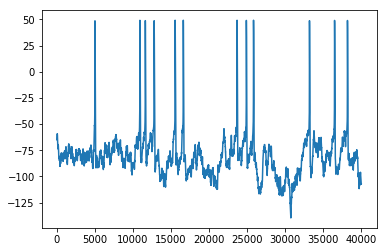

In [7]:
voltage1 = mon.v[0]/mV
plot(voltage1);

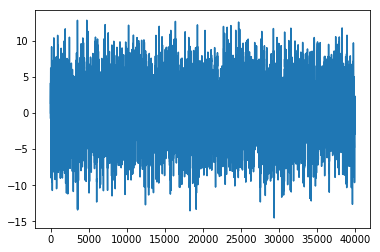

In [8]:
inp_cur1 = mon.I[0]/nA
plot(inp_cur1);

In [9]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([ 49.78, 108.85, 115.97, 127.58, 155.14, 165.88, 236.55, 248.76,
        258.18, 331.71, 364.68, 381.62])]

In [10]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


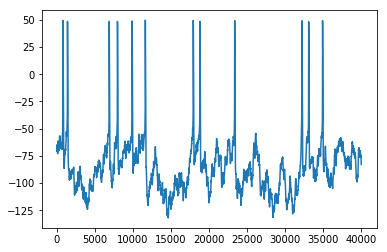

In [11]:
voltage2 = mon.v[0]/mV
plot(voltage2);

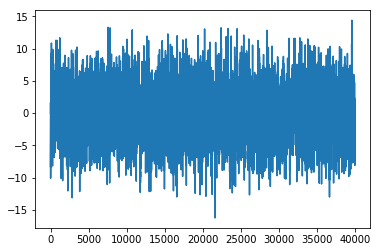

In [12]:
inp_cur2 = mon.I[0]/nA
plot(inp_cur2);

In [13]:
out_spikes2 = [spike_mon.spike_trains()[0]/ms]
out_spikes2

[array([  7.74,  13.67,  68.51,  79.36,  98.65, 115.96, 178.99, 187.72,
        233.4 , 321.82, 330.67, 348.92])]

In [14]:
out_spikes1

[array([ 49.78, 108.85, 115.97, 127.58, 155.14, 165.88, 236.55, 248.76,
        258.18, 331.71, 364.68, 381.62])]

In [15]:
out_spikes = [out_spikes1[0], out_spikes2[0]]
out_spikes

[array([ 49.78, 108.85, 115.97, 127.58, 155.14, 165.88, 236.55, 248.76,
        258.18, 331.71, 364.68, 381.62]),
 array([  7.74,  13.67,  68.51,  79.36,  98.65, 115.96, 178.99, 187.72,
        233.4 , 321.82, 330.67, 348.92])]

In [16]:
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        ,  3.55866369,  4.14464342, ...,  1.02567164,
        -0.05682181, -0.34108968]),
 array([ 0.        ,  1.22314003,  1.66601065, ..., -4.71697634,
        -3.3019515 , -4.13195784])]

## Model Fitting

In [17]:
eqs = Equations(
"""
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
taum = C / gL : second
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
k : 1 (constant)
C : farad (constant)
tauw : second (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
# C = 171 * pF,
# tauw = 144*ms,
EL = -65 * mV,
)

In [18]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=30*ms)

In [19]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=60,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     refractory=1.41*ms,
                     param_init={'v': -65*mV},
                     )

In [20]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[30*nS, 60*nS],
                                a = [0, 20]*nS,
                                b = [0, 2]*nA,
                                VT = [-90, -10] * mV,
                                DeltaT = [5, 8] * mV,    
                                Vr = [-90, -30]*mV,
                                k = [0.01, 2],
                                C = [170, 200] * pF,
                                tauw = [0.1, 500]*ms,
                               )

WARNING    "VT" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value -63. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    neurons's variable 'w' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


Round 0: fit (0.006517472204720331, 0.9937464007309793, 0.120515997072588, 1.947915044109924e-10, -0.07332636862439013, -0.07785612896091124, 6.205139146772535e-09, 4.382195440069278e-08, 4.799003091037152e-10) with error: 1.8293135435992578
Round 1: fit (0.006170909387381532, 0.9781589526653901, 0.08276511904414657, 1.9706540420029249e-10, -0.06320263204533698, -0.07793875953431059, 1.723492201198395e-08, 4.882635976938113e-08, 2.2668867688011697e-10) with error: 0.8877551020408163
Round 2: fit (0.006170909387381532, 0.9781589526653901, 0.08276511904414657, 1.9706540420029249e-10, -0.070723113403519, -0.0827848713715734, 1.723492201198395e-08, 5.1880858246979595e-08, 2.2668867688011697e-10) with error: 0.31836734693877533
Round 3: fit (0.006950320651965505, 0.6616851187691242, 0.08006126559388005, 1.9167422388460208e-10, -0.07513257346057406, -0.08211617423941711, 1.83815794762576e-08, 5.166956447077542e-08, 1.9419367777894073e-10) with error: 0.04081632653061229
Round 4: fit (0.00695

In [21]:
result_dict

{'DeltaT': 0.007135826734172956,
 'k': 0.7734783901633182,
 'tauw': 0.0817281987951595,
 'C': 1.9744563231821024e-10,
 'VT': -0.06964557186924106,
 'Vr': -0.07922867790156417,
 'a': 8.650089821335855e-09,
 'gL': 5.5153985011795374e-08,
 'b': 1.283311358648319e-10}

In [22]:
error

0.010627177700348489

In [23]:
1 - error

0.9893728222996515

In [24]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

WARNING    "VT" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value -63. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


spike times: [array([  4.4 ,  11.38,  20.9 ,  31.03,  44.32,  49.65,  67.06,  77.82,
       104.34, 109.41, 114.71, 122.53, 153.02, 164.32, 185.35, 216.07,
       229.05, 237.07, 245.64, 254.94, 259.9 , 272.8 , 321.56, 328.01,
       337.42, 362.46, 365.77, 376.44, 385.32]), array([  2.36,   7.77,  10.45,  14.28,  48.25,  61.15,  67.89,  76.57,
        83.08,  97.27, 107.94, 129.37, 164.92, 175.17, 179.06, 182.66,
       208.92, 225.39, 233.82, 258.81, 293.77, 318.5 , 321.37, 328.32,
       345.62, 350.06, 367.86, 391.77])]


In [25]:
print(len(out_spikes[0]))
print(len(spikes[0]))

12
29


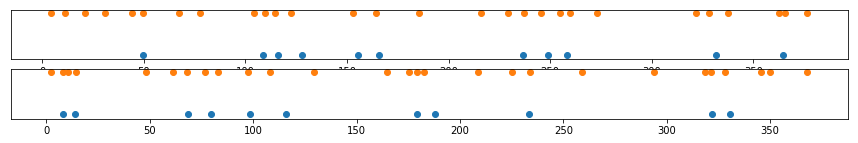

In [26]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);